# Likelihood of existing Sinkhole - Metric Analysis

How to combine the sinkhole size and detectability power to produce a likelihood of the existance of an impending sinkhole.

Likelihood of Impending Sinkhole = Model fit * ((R-r/R * Detectability Power) + (R-r/R * Detectability Power))

$$\beta = H_1 \sum_i \frac{R-r_i}{R}\gamma_{0,i}$$

The further away the points are from the center, the higher the Signal to Noise Ratio is.

## Components
- Minimal Detectable Size
- Detectability Power
- Maximum Sinkhole Development Rate

## Roadmap
- Create a testing plan based on the scientific method
- Define simulation scheme for points and subsidence pattern
- Define sinkhole parameter retrieval scheme
- Implement algorithm to assign likelihood to each retrieval step

### Scientific Method
1.	Constructing a Hypothesis<br>
    a.	Ask Questions<br>
    b.	Do some background research<br>
    c.	Answer those questions with a hypothesis<br>
    d.	Use the hypothesis to make some prediction<br>
2.	Testing the Hypothesis<br>
    a.	Design an experiment<br>
    b.	Carry out the experiment<br>
    c.	Troubleshoot if necessary<br>
3.	Sharing Your Results<br>
    a.	Analyze experimental data<br>
    b.	Make conclusions based on the data<br>
    c.	Replicate the experiment<br>
    d.	Share your experiment and results with others<br>

### Notes
- Quickly apply the method to the digitized sinkholes?
    - There is no point noise i.e. detectability power
    - To many point -> beed a subsampling

# Maximum Sinkhole Development Rate
The explaining variable is going to be the $v$, the velocity of subsidence. Input variables are the maximum unwrapping threshold, the revisit time and the sinkhole size. This will not apply to a grid, but to the points themselve. The same as the detectability power. 

What does it say? It will counter the unwrapping errors due to the wrapping threshold. Thus, with other words, to what degree can the neighboring points correct the point with the unwrapping error.

I don't think I should pursue this any further.

# Other Maximum likelihood of detection
Define the maximum subsidence at the specific point and the $R$, radius of influence, size. Using the nearest measurement point, compute the deformation present at that point with the corresponding detectability power. This is the likelihood of detection? Maybe combine more points using weight defined on radial distance?

# Scientific Method

## Hypothesis
- When simulating data and randomly (using random epochs and sinkhole size) implementing a sinkhole, the likelihood will rise (step-wise) for the epochs and location of the impending sinkhole. 

In [1]:
#imports
import os, sys, time
import numpy as np
import pandas as pd
import datetime, re
import matplotlib.pyplot as plt
from scipy import spatial
from scipy.stats import norm
import scipy
from tqdm import tqdm

In [2]:
folder = 'data'
filename = 'Catharina_Neu_Prick_r200m_full-pixel_mrss_s1_asc_t88_v4_080a1cbf7de1b6d42b3465772d9065fe7115d4bf.csv'

#data
data = pd.read_csv(os.path.join(folder,filename))

## Metrics
- Minimum Detectable Size
- Detectability Power
- Model Fit

In [3]:
'''
Functions for the Minimal Detectable Size of a sinkhole
'''
def zg(R,r):
    return np.exp(-np.pi*(r**2/R**2))

def cond_check(design_matrix,r):
    # is r is empty then there are no point within the vicinity
    if len(r)==0:
        return 0
    else:
        cond_number = np.linalg.cond(design_matrix)

    # print('Check the magnitude of the conditional number.')
    if cond_number > 1/sys.float_info.epsilon:
        return 0
    else:
        return 1 

def check_subset(data,x0,y0,stepsize=1):
    '''
    The R is predefined making it a linear problem
    
    Returns an array of possible sinkholes
    '''
    n = 255 #number of iterations
    search_radius = np.linspace(n*stepsize,1,n)
    
    sinkhole_radii = np.zeros((1,n))
    
    tree = spatial.cKDTree(data[['pnt_rdx','pnt_rdy']])
    
    for i in search_radius:
        # the search radius is the radius of influence (R)
        subset = tree.query_ball_point([x0,y0],r=i)
        data_subset = data.iloc[subset]
        
        r = np.sqrt((data_subset['pnt_rdx'].values-x0)**2 + (data_subset['pnt_rdy'].values-y0)**2)

        # print('Making Design Matrix.')
        design_matrix = np.array([zg(i,r)])

        #result is either a 0 or a 1
        result = cond_check(design_matrix,r)
        sinkhole_radii[1,i]=result
    
    return sinkhole_radii        

In [4]:
'''
Function for the Detectability Power
'''
def get_sentinel_epochs(header_list):
    filter_option = re.compile(r'd_\d{8}')
    epochs = list(filter(lambda x: filter_option.match(x) != None, header_list))  
    return epochs

def linear_model(epochs,data):
    '''
    Function creating the linear model for detect arcs behaving anomalous
    '''

    #creating time vector
    delta_days, start_day = get_delta_day(epochs)

    #pre-allocate space for the output variables
    a = []
    b = []
    sigma_ehat = []
    ehat_out = {}

    for i in range(len(data)):
        '''
        Loop creating a linear model per row
        '''

        #setting up the system of equations
        y = np.array(data[epochs].iloc[i])
        A = np.array((delta_days,np.ones([len(delta_days)])))

        #stochastic matrix
        W = np.eye((len(y)))

        #compute solutions
        invW = np.linalg.inv(W)
        Qxhat = np.linalg.inv(A @ invW @ A.T)
        xhat = Qxhat @ A @ invW @ y

        yhat = A.T @ xhat
        ehat = y - yhat

        #compute the standard deviation of the noise of an arc
        sigma_ehat_out = np.sqrt((np.sum((ehat - np.mean(ehat))**2))/len(y))

        #saving the data
        a.append(xhat[0])
        b.append(xhat[1])
        sigma_ehat.append(sigma_ehat_out)
#         ehat_out[str(i)] = ehat

    return a, b, sigma_ehat

def get_delta_day(epochs):
    '''
    Method for getting the time series
    '''
    dates = list(map(lambda x: datetime.datetime.strptime(x,'d_%Y%m%d'),epochs))
    start_date = dates[0]
    dates_days = np.array(list(map(lambda x: (x-start_date).days,dates)))

    return dates_days, start_date

def solve(m1,m2,std1,std2):
    a = 1/(2*std1**2) - 1/(2*std2**2)
    b = m2/(std2**2) - m1/(std1**2)
    c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
    return np.roots([a,b,c])

def function2(m2,input_var):
    sigma, decpow = input_var
    m1 = 0
#     item = 0.003
    result = solve(m1,m2,sigma,sigma)
    r = result[0]
    return 1-(norm.cdf(r,m2,sigma) + (1-norm.cdf(r,m1,sigma))) - decpow

In [5]:
'''
Functions for the model fit

The fit will only determine the subsidence velocity (v). Thus, the equation will be a linear one.
'''

def kinematic_model(R,r,y_data):
    '''
    Function to determine the subsidence velocity
    '''
    #creating the LSQ
    A = zg(R,r) #len(x_range) by 1 matrix
#     print(A,type(A),R,r)
    y = y_data

    A = A.reshape((1,len(y)))

    #stochastic matrix
    W = np.eye((len(y)))

    #compute solutions
    invW = np.linalg.inv(W)
    try:
        Qxhat = np.linalg.inv(A @ invW @ A.T)
    except:
        print('Exception...')
        return 0,0
    
    #the subsidence velocity
    xhat = Qxhat @ A @ invW @ y

    yhat1 = A.T @ xhat
    ehat = y - yhat1
    
    fit = 100*(1-(np.sum(ehat @ ehat.T)/np.sum((y_data-np.mean(y_data))**2)))
    
    return xhat, fit

In [6]:
#tree = spatial.cKDTree(data[['pnt_rdx','pnt_rdy']])make quick subset
x0 = 202900 #[m]
y0 = 318750 #[m]
i = 50 #[m]

tree = spatial.cKDTree(data[['pnt_rdx','pnt_rdy']])

subset = tree.query_ball_point([x0,y0],r=i)
data_subset = data.iloc[subset]

# plt.figure()
# plt.scatter(data_subset['pnt_rdx'],data_subset['pnt_rdy'])

In [7]:
'''
implement roadmap
- implement a sinkhole in the last 5 epochs and at a predetermined position (to be sure to get a return)
- define a grid
- set R to 20
- determine the noise level of each point using n epochs
- Only use the deformation time series of the last epoch
- Implement 'Impending Sinkhole likelihood'
'''

# Implement the sinkhole
#sinkhole location
x0_s = 202920
y0_s = 318740

#get the last 5 epochs
epochs = get_sentinel_epochs(list(data_subset))

last_epochs = epochs[-5:]

#delta days
days, start_day = get_delta_day(last_epochs)

max_sub = 0.08 #[m]
v = max_sub/days[-1] #[m/day]
R_sinkhole = 10 #[m]

r = np.sqrt((data_subset['pnt_rdx'].values-x0_s)**2 + (data_subset['pnt_rdy'].values-y0_s)**2)

#add sinkhole to the dataset
for epoch, day in zip(last_epochs,days):
    data_subset[epoch].iloc[:] = data_subset[epoch].iloc[:]-v*day*zg(R_sinkhole,r)
    
data_subset = data_subset.reset_index();

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-7-962eaa502a27>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset[epoch].iloc[:] = data_subset[epoch].iloc[:]-v*day*zg(R_sinkhole,r)


In [8]:
#define a grid
n_grid = 30
# data_subset['pnt_rdx'],data_subset['pnt_rdy']
x_range = np.linspace(min(data_subset['pnt_rdx']),max(data_subset['pnt_rdx']),n_grid)
y_range = np.linspace(min(data_subset['pnt_rdy']),max(data_subset['pnt_rdy']),n_grid)

xv, yv = np.meshgrid(x_range,y_range)

In [9]:
#determine noise level of each point

epochs = get_sentinel_epochs(list(data))
a, b, sigma_ehat = linear_model(epochs,data_subset)

delta_days = get_delta_day(epochs)

# add the noise to the pandas dataframe
data_subset = data_subset.join(pd.DataFrame(np.array(sigma_ehat).T,columns=['Noise']))

In [10]:
# Only use the deformation time series of the last epoch
i_epoch = -3

data_defo = data_subset[last_epochs[i_epoch]]

In [11]:
# Implement 'Impending Sinkhole likelihood'
'''
Step for implementing the sinkhole likelihood

- create iteration scheme for looping over the grid
- are we going to make subsets on each grid location? -> yes, subset radius is predefined sinkhole size
- create model fit and determine the DP of the deformation in each point
- Combine both metrics in a value
'''
n_total = xv.shape[0] * xv.shape[1]
radi_sub = R_sinkhole

#saving the beta
beta = np.zeros(xv.shape)
beta_u = beta.ravel()

tree = spatial.cKDTree(data_subset[['pnt_rdx','pnt_rdy']])
# data_subset = data.iloc[subset]
xv_u = xv.ravel()
yv_u = yv.ravel()

for ii in tqdm(range(n_total),desc='Looping over the grid'):
    x0 = xv_u[ii]
    y0 = yv_u[ii]
    
    #make subset
    subset = tree.query_ball_point([x0,y0],r=radi_sub)
    data_subset2 = data_subset.iloc[subset]
    
    #determine the fit of the points
    r = np.sqrt((data_subset2['pnt_rdx'].values-x0)**2 + (data_subset2['pnt_rdy'].values-y0)**2)
    xhat,mfit = kinematic_model(radi_sub,r,data_subset2[last_epochs[i_epoch]])
    
    if mfit < 0:
        mfit = 0

    #determine the DP of each point
    dec_pow = []
    m1 = 0
    m2 = 0.01 # 1cm

    for item in data_subset2['Noise']:
        result = solve(m1,m2,item,item)
        r = result[0]
        area = 1-(norm.cdf(r,m2,item) + (1-norm.cdf(r,m1,item)))
        dec_pow.append(area)
    
    np_dec_pow = np.array(dec_pow)
    
    beta_u[ii] = (mfit/100)*np.sum(((radi_sub-r)/radi_sub)*np_dec_pow)

Looping over the grid:   1%|          | 7/900 [00:00<00:15, 59.33it/s]<ipython-input-5-8887eb788cc1>:35: RuntimeWarning: divide by zero encountered in double_scalars
  fit = 100*(1-(np.sum(ehat @ ehat.T)/np.sum((y_data-np.mean(y_data))**2)))
<ipython-input-5-8887eb788cc1>:35: RuntimeWarning: invalid value encountered in double_scalars
  fit = 100*(1-(np.sum(ehat @ ehat.T)/np.sum((y_data-np.mean(y_data))**2)))


Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...


Looping over the grid:   6%|▌         | 51/900 [00:00<00:11, 77.00it/s]

Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...


Looping over the grid:  11%|█         | 101/900 [00:00<00:07, 107.27it/s]

Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...


Looping over the grid:  16%|█▌        | 144/900 [00:01<00:06, 120.05it/s]

Exception...
Exception...
Exception...
Exception...


Looping over the grid:  19%|█▉        | 172/900 [00:01<00:05, 122.02it/s]

Exception...
Exception...
Exception...


Looping over the grid:  21%|██        | 185/900 [00:01<00:06, 106.75it/s]

Exception...
Exception...


Looping over the grid:  24%|██▍       | 218/900 [00:02<00:10, 63.73it/s] 

Exception...
Exception...


Looping over the grid:  29%|██▉       | 259/900 [00:02<00:07, 83.37it/s]

Exception...


Looping over the grid:  30%|██▉       | 269/900 [00:02<00:07, 81.81it/s]

Exception...


Looping over the grid:  36%|███▌      | 322/900 [00:03<00:07, 81.57it/s]

Exception...
Exception...


Looping over the grid:  73%|███████▎  | 653/900 [00:07<00:01, 135.11it/s]

Exception...
Exception...
Exception...


Looping over the grid:  78%|███████▊  | 700/900 [00:07<00:01, 121.00it/s]

Exception...
Exception...


Looping over the grid:  82%|████████▏ | 737/900 [00:07<00:01, 93.86it/s] 

Exception...
Exception...


Looping over the grid:  84%|████████▍ | 759/900 [00:08<00:02, 66.99it/s]

Exception...
Exception...
Exception...
Exception...


Looping over the grid:  88%|████████▊ | 794/900 [00:08<00:01, 76.53it/s]

Exception...
Exception...
Exception...
Exception...
Exception...


Looping over the grid:  92%|█████████▏| 830/900 [00:09<00:00, 73.42it/s]

Exception...
Exception...
Exception...
Exception...
Exception...


Looping over the grid:  97%|█████████▋| 876/900 [00:09<00:00, 111.84it/s]

Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...


Looping over the grid: 100%|██████████| 900/900 [00:09<00:00, 93.03it/s] 

Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...


In [12]:
def binary_out(input1):
    if input1 > 0.7:
        return 1
    else:
        return 0

beta_x = list(map(binary_out,beta_u))

beta_y = beta_u/max(beta_u)
beta_g = list(map(binary_out,beta_y))

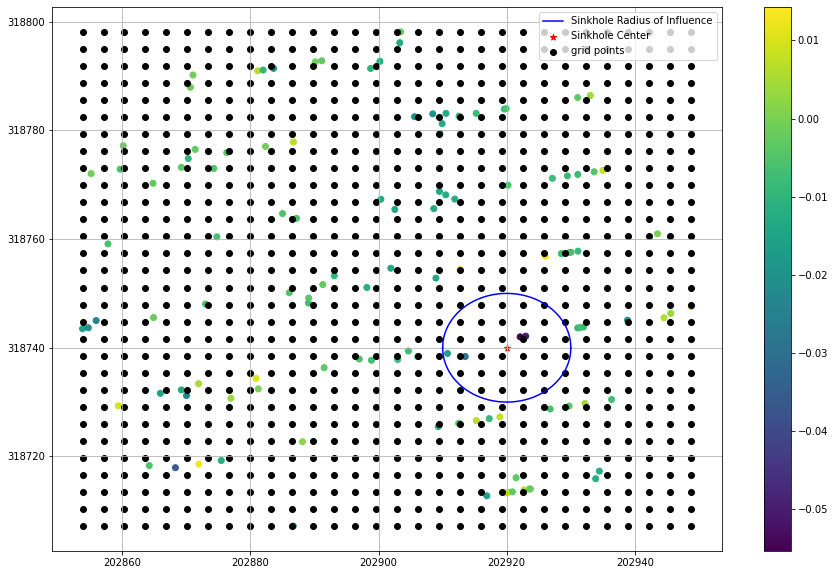

In [13]:
plt.figure(figsize=(15,10))
p = plt.scatter(data_subset['pnt_rdx'],data_subset['pnt_rdy'],c=data_subset[last_epochs[-1]])
# p = plt.scatter(xv_u,yv_u,c=beta_x)
# p = plt.scatter(xv_u,yv_u,c=beta_y,cmap='jet')
# p = plt.scatter(xv_u,yv_u,c=beta_g)
# p = plt.scatter(xv_u,yv_u,c=beta_u)
plt.scatter(x0_s,y0_s,marker='*',c='r',s=40,label='Sinkhole Center')

#plot the radius of influence
x = np.linspace(x0_s-R_sinkhole,x0_s+R_sinkhole,500)
y1 = np.sqrt(R_sinkhole**2 - ((x-x0_s)**2))+y0_s
y2 = y0_s - np.sqrt(R_sinkhole**2 - ((x-x0_s)**2))

#show the radius of influence
plt.plot(x,y1,c='b')
plt.plot(x,y2,c='b',label='Sinkhole Radius of Influence')

#implement the grid
plt.scatter(xv,yv,c='k',label='grid points')

plt.colorbar(p)
plt.legend()
plt.grid(True);

In [14]:
epochs = get_sentinel_epochs(list(data))
a, b, sigma_ehat = linear_model(epochs,data)

delta_days = get_delta_day(epochs)

dec_pow = []
m1 = 0
m2 = 0.01 # 1cm

for item in sigma_ehat:
    result = solve(m1,m2,item,item)
    r = result[0]
    area = 1-(norm.cdf(r,m2,item) + (1-norm.cdf(r,m1,item)))
    dec_pow.append(area*100)

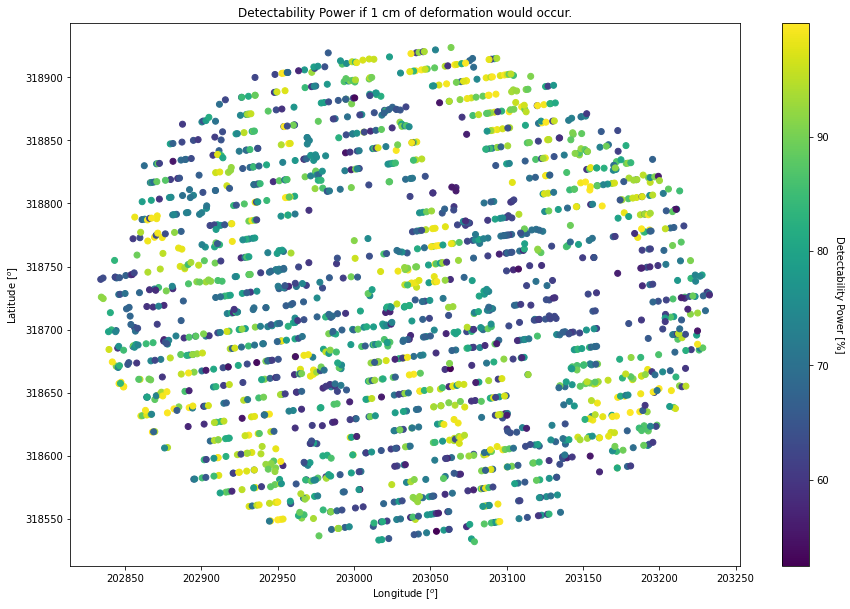

In [15]:
plt.figure(figsize=(15,10))
p = plt.scatter(data['pnt_rdx'],data['pnt_rdy'],c=dec_pow)
clb = plt.colorbar(p)
clb.set_label("Detectability Power [%]",rotation=270,labelpad=15)

plt.title('Detectability Power if 1 cm of deformation would occur.')
plt.xlabel('Longitude [$^o$]')
plt.ylabel('Latitude [$^o$]');

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


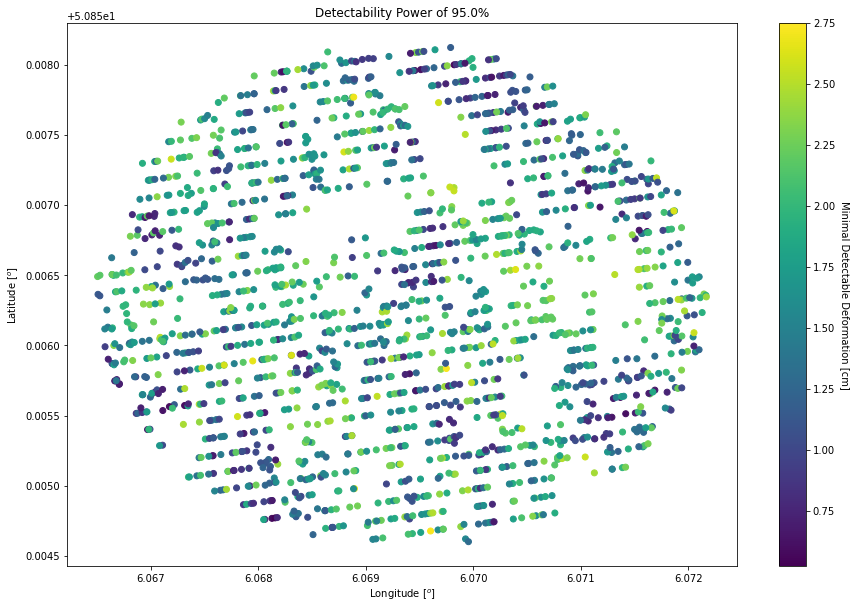

In [16]:
MDD = []
decpow = 0.95

for item in sigma_ehat:
    input_var = [item,decpow]
    MDD.append(100*scipy.optimize.fsolve(function2,item,input_var))

plt.figure(figsize=(15,10))
p = plt.scatter(data['pnt_lon'],data['pnt_lat'],c=MDD)
clb = plt.colorbar(p)
clb.set_label("Minimal Detectable Deformation [cm]",rotation=270,labelpad=15)

plt.title(f'Detectability Power of {decpow*100}%')
plt.xlabel('Longitude [$^o$]')
plt.ylabel('Latitude [$^o$]');

In [17]:
np.linspace(10,1,10)

array([10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.])